[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)


# snnTorch - Training Spiking Neural Networks with snnTorch
## Tutorial 5
### By Jason K. Eshraghian (www.ncg.ucsc.edu)
### 偏白话文翻译： manesec

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_6_CNN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

snnTorch 教程系列基于以下论文。如果您发现这些资源或代码对您有帮助，请考虑引用以下来源：

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>



# 介绍

在本教程中，您将
* 了解尖峰神经元是如何作为递归网络实现的
* 了解时间反向传播以及 SNNs 中的相关难题，如尖峰的不可微分性 (指不存在导数的函数)
* 在静态 MNIST 数据集上训练全连接网络

<!-- * Implement various backprop strategies:
  * Backpropagation Through Time
  * Truncated-Backpropagation Through Time
  * Real-Time Recurrent Learning -->

>本教程的部分内容受到 Friedemann Zenke 关于 SNN 的大量工作的启发，请查看他关于代梯度的资料库 [此处](https://github.com/fzenke/spytorch)，以及我最喜欢的一篇论文： E. O. Neftci、H. Mostafa、F. Zenke，[尖峰神经网络中的代梯度学习： 将基于梯度的优化功能引入尖峰神经网络](https://ieeexplore.ieee.org/document/8891809) IEEE Signal Processing Magazine 36, 51-63。

在教程的最后，我们将实施一种基本的监督学习算法。我们将使用原始静态 MNIST 数据集，并使用梯度下降训练多层全连接尖峰神经网络来执行图像分类。

如果在 Google Colab 中运行：
* 您可以通过检查 `Runtime` > `Change runtime type` > `Hardware accelerator： GPU`
* 接下来，点击下面的单元格并按下 `Shift+Enter` 键，安装 snnTorch 的最新 PyPi 发行版。

In [1]:
!pip install snntorch

In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

# 1. SNN 的递归表示

在 教程3 中，我们导出了 带泄漏整合发放（LIF）神经元的递归表示法：

$$U[t+1] = \underbrace{\beta U[t]}_\text{decay} + \underbrace{WX[t+1]}_\text{input} - \underbrace{R[t]}_\text{reset} \tag{1}$$

其中，输入突触电流被解释为 $I_{\rm in}[t] = WX[t]$，而 $X[t]$ 可以是一些任意的尖峰输入、阶跃/时变电压(step/time-varying voltage) 或 非加权阶跃/时变电流(unweighted step/time-varying current) 。尖峰脉冲用以下公式表示，如果膜电位超过阈值，就会发出尖峰脉冲：

$$S[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{otherwise}\end{cases} \tag{2}$$

这种离散递归形式的尖峰神经元几乎表述完全可以利用 训练递归神经网络（RNN）和 基于序列模型 的发展。下图使用*隐式*递归连接来说明膜电位的衰减，与*显式*递归有所区别，*显式*递归将输出尖峰 $S_{\rm out}$ 反馈到输入。在下图中，$-U_{\rm thr}$加权的连接代表了复位机制$R[t]$。

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/unrolled_2.png?raw=true' width="800">
</center>

展开图的好处在于，它明确描述了计算是如何进行的。展开过程说明了信息流在时间上的前向（从左到右），以计算输出和损失，以及在时间上的后向，以计算梯度。模拟的时间步数越多，图就越深。

传统的 RNN 将 $\beta$ 作为可学习的参数。这对 SNN 也是可行的，不过默认情况下，它们被视为超参数。这就用超参数搜索取代了梯度消失和梯度爆炸问题。未来的教程将介绍如何将 $\beta$ 作为可学习参数。

# 2. 尖峰的不可微分性
## 2.1 使用反向预测算法进行训练

$(2)$中$S$和$U$之间关系的另一种表示方法是

$$S[t] = \Theta(U[t] - U_{\rm thr}) \tag{3}$$

其中 $\Theta(\cdot)$ 是单位阶跃函数：

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_2_spike_descrip.png?raw=true' width="600">
</center>

训练这样的网络会比较麻烦，请参考上图 “尖峰神经元的循环表示 (Recurrent representation of spiking neurons)” 的每个计算周期， 如下面的 “前向传播” 所示

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/non-diff.png?raw=true' width="400">
</center>

目标是使用损失相对于权重的梯度来训练网络，以便更新权重以最小化损失。 反向传播算法使用链式法则实现这一点：

$$\frac{\partial \mathcal{L}}{\partial W} =
\frac{\partial \mathcal{L}}{\partial S}
\underbrace{\frac{\partial S}{\partial U}}_{\{0, \infty\}}
\frac{\partial U}{\partial I}\
\frac{\partial I}{\partial W}\ \tag{4}$$

从 $(1)$，$\partial I/\partial W=X$，和 $\partial U/\partial I=1$。 虽然还没有定义损失函数，但可以假设 $\partial \mathcal{L}/\partial S$ 有一个解析解，其形式与交叉熵或均方误差损失类似（简单地讲）。

然而，我们要解决的术语是$\partial S/\partial U$。 单位跃迁函数从 $(3)$ 导出的导数是狄拉克 Delta 函数，除了在阈值 $U_{\rm thr} = \theta$ 处趋于无穷大之外，它在任何地方的计算结果都为 0。 这意味着梯度几乎总是为零（或者如果 $U$ 恰好位于阈值则饱和），这样就无法进行学习，这被称为**死神经元问题**。

## 2.2 解决死亡神经元问题

解决死神经元问题的最常见方法是 在前向传递过程中保持单位跃迁函数不变，但将导数项 $\partial S/\partial U$ 交换的项 不会在后向传递过程中终止学习过程，将其表示为$\partial \tilde{S}/\partial U$。 这可能听起来很奇怪，但事实证明神经网络对于这种近似非常稳健。 这通常称为“替代梯度”方法。

使用代替梯度的方法有很多种选择，我们将在[教程 6](https://snntorch.readthedocs.io/en/latest/tutorials/index.html) 中更详细地介绍这些方法。 snnTorch 中的默认方法（从 v0.6.0 开始）是使用反正切函数 平滑的代替 单位跃迁函数。 使用的后向传递导数为：

$$ \frac{\partial \tilde{S}}{\partial U} \leftarrow \frac{1}{\pi}\frac{1}{(1+[U\pi]^2)} \tag{5}$$

其中左箭头表示替换。

下面用 PyTorch 实现了 $(1)-(2)$ 中描述的同一个神经元模型（又名教程 3 中的 `snn.Leaky` 神经元）。如果您不理解，请不要担心。稍后我们将使用 snnTorch 将其浓缩为一行代码：

In [3]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
      super(LeakySurrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.spike_gradient = self.ATan.apply

  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.spike_gradient((mem-self.threshold))  # call the Heaviside function
    reset = (self.beta * spk * self.threshold).detach() # remove reset from computational graph
    mem = self.beta * mem + input_ - reset # Eq (1)
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with the ArcTan function
  @staticmethod
  class ATan(torch.autograd.Function):
      @staticmethod
      def forward(ctx, mem):
          spk = (mem > 0).float() # Heaviside on the forward pass: Eq(2)
          ctx.save_for_backward(mem)  # store the membrane for use in the backward pass
          return spk

      @staticmethod
      def backward(ctx, grad_output):
          (mem,) = ctx.saved_tensors  # retrieve the membrane potential
          grad = 1 / (1 + (np.pi * mem).pow_(2)) * grad_output # Eqn 5
          return grad

请注意，重置机制与计算图分离，因为代替梯度的方法只能应用于 $\partial S/\partial U$，而不是 $\partial R/\partial U$。

上述神经元使用以下实例化：

In [4]:
lif1 = LeakySurrogate(beta=0.9)

这个神经元可以使用 for 循环进行模拟，就像之前的教程一样，而 PyTorch 的自动微分器 (autodiff) 会在后台自动跟踪梯度。

或者，也可以使用`snn.Leaky`神经元来完成同样的事情。

事实上，每次您从 snnTorch 调用任何神经元模型时，默认情况下都会对其应用 *ATan* 来代替梯度：

In [5]:
lif1 = snn.Leaky(beta=0.9)

如果您想了解该神经元的行为，请参阅 [教程 4](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)。

# 3. 时间反向传播
等式 $(4)$ 只计算一个时间步的梯度（下图中称为*直接影响*），但通过时间反向传播（BPTT）算法会计算从损失到*所有*后代的梯度，并将它们相加。

权重 $W$ 应用于每个时间步长，因此也可以想象损失也是在每个时间步长计算的。权重对当前损失和历史损失的影响必须相加才能确定全局梯度：


$$\frac{\partial \mathcal{L}}{\partial W}=\sum_t \frac{\partial\mathcal{L}[t]}{\partial W} =
\sum_t \sum_{s\leq t} \frac{\partial\mathcal{L}[t]}{\partial W[s]}\frac{\partial W[s]}{\partial W} \tag{5} $$

$(5)$的意义在于确保因果关系：通过约束$s\leq t$，我们只考虑 $W$ 对损失的直接影响 和 对之前的影响。循环系统会让所有步骤的权重都相等： $w[0]=w[1] =~... ~ = W$. 因此，改变 $W[s]$ 相当于改变所有 $W$，所以 $\partial W[s]/\partial W=1$：

$$\frac{\partial \mathcal{L}}{\partial W}=
\sum_t \sum_{s\leq t} \frac{\partial\mathcal{L}[t]}{\partial W[s]} \tag{6} $$

例如，只考虑之前 $s = t-1$ 的影响，向后传递必须在时间上向前一步。$W[t-1]$对损失的影响可以写成

$$\frac{\partial \mathcal{L}[t]}{\partial W[t-1]} =
\frac{\partial \mathcal{L}[t]}{\partial S[t]}
\underbrace{\frac{\partial \tilde{S}[t]}{\partial U[t]}}_{Eq.~(5)}
\underbrace{\frac{\partial U[t]}{\partial U[t-1]}}_\beta
\underbrace{\frac{\partial U[t-1]}{\partial I[t-1]}}_1
\underbrace{\frac{\partial I[t-1]}{\partial W[t-1]}}_{X[t-1]} \tag{7}$$

上面已经处理了 $(4)$ 中的所有这些项，除了 $\partial U[t]/\partial U[t-1]$。 从 $(1)$ 开始，这个时间导数项简单地计算为 $\beta$。 因此，如果真的愿意，知道了足够多的知识，可以手动计算每个权重在每个时间步长的导数，对于单个神经元来说，它看起来像这样：

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/bptt.png?raw=true' width="600">
</center>

但值得庆幸的是，PyTorch 的自动差异功能在后台为我们解决了这个问题。

*注：上图中省略了复位机构。 在snnTorch中，重置机制包含在前向传递中，但与后向传递分离。*

# 4. 设置损失函数和输出编码

在传统的非尖峰神经网络中，有监督的多类分类问题会选择激活度最高的神经元作为预测类别。

在尖峰神经网络中，有几种解释输出尖峰的方法。最常见的方法有
* **速率编码：** 生成尖峰的速率（或尖峰计数）最高的神经元作为预测类别。
* **延迟编码：** 将*先* 生成尖峰的神经元作为预测类别


这可能与[神经编码教程 1](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)有些相似。不同之处在于，在这里我们是解释（解码）输出尖峰，而不是将原始输入数据编码/转换成尖峰。

让我们关注速率编码。当输入数据传递给网络时，我们希望正确的神经元类在模拟运行过程中发出最多的尖峰。这就相当于最高的平均发射频率。实现这一目标的方法之一是将正确类神经元的膜电位增加到 $U>U_{\rm thr}$，而将错误类神经元的膜电位增加到 $U<U_{\rm thr}$。 $U$ 就像模拟 $S$ 的行为，就像代理人。

这可以通过输出神经元膜电位的 softmax 来实现，其中 $C$ 是输出类别的数量：

$$p_i[t] = \frac{e^{U_i[t]}}{\sum_{j=0}^{C}e^{U_j[t]}} \tag{8}$$

利用下面的方法可以得到 $p_i$ 和目标 $y_i \ in \{0,1\}^C$ 之间的交叉熵 （one-hot 目标向量）：

$$\mathcal{L}_{CE}[t] = -\sum_{i=0}^Cy_i{\rm log}(p_i[t]) \tag{9}$$

其实际效果是，正确分类的膜电位被鼓励增加，而不正确分类的膜电位则被降低。这意味着在所有时间步骤中，正确分类会被鼓励生成尖峰，而不正确的分类则会在每个步骤中抑制生成尖峰。虽然这不是最有效的 SNN 方法，但却是最简单的方法之一。

在每个仿真的时间段内都会应用，因此每个步长也会产生损失。这些损失会在仿真结束时相加：

$$\mathcal{L}_{CE} = \sum_t\mathcal{L}_{CE}[t] \tag{10}$$

这只是将损失函数应用于尖峰神经网络的多种可能方法之一。在 snnTorch 的 `snn.functional` 模块中有多种方法，这将是未来教学的主题。

在了解了所有的背景理论后，开始来深入探讨 如何训练全连接尖峰神经网络。

# 5. 设置静态 MNIST 数据集

In [6]:
# dataloader arguments
batch_size = 128
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

如果上述代码块出现错误，例如 MNIST 服务器宕机，则取消对以下代码的注释。

In [8]:
# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

In [9]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

# 6. 定义网络

In [10]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [11]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)


只有在输入参数 `x` 明确传入 `net` 后，才会调用 `forward()` 函数中的代码。

* `fc1` 对来自 MNIST 数据集的所有输入像素进行线性变换；
* `lif1` 对加权输入进行时间积分，如果满足阈值条件，就会产生一个尖峰；
* `fc2` 对 `lif1` 的输出尖峰进行线性变换；
* `lif2` 是另一个尖峰神经元层，对加权尖峰进行时间积分。

# 7. 训练SNN

## 7.1 精度指标

下面是一个函数，它获取一批数据，对每个神经元的所有尖峰进行计数（即模拟时间内的速率代码），并将最高计数的索引与实际目标进行比较。如果两者匹配，则说明网络正确预测了目标。

In [12]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

## 7.2 定义损失

PyTorch 中的 `nn.CrossEntropyLoss`函数 会自动处理 输出层的 softmax 并在输出处生成损失。

In [13]:
loss = nn.CrossEntropyLoss()

## 7.3 优化

Adam 是一个强大的优化器，在循环网络上表现良好，因此我们以 $5\times10^{-4}$ 的学习率使用它。

In [14]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

## 7.4 训练的一次迭代

获取第一批数据并将其加载到 CUDA（如果可用）。

In [15]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

将输入数据进行扁平化（Flatten）处理，为大小 $784$ 的矢量，然后传入网络。

In [16]:
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

torch.Size([25, 128, 10])


膜电位记录跨度为
* 25 个时间步长
* 128 个数据样本
* 10 个输出神经元

我们希望计算每个时间步长的损失，并按照公式 $(10)$ 将这些损失相加：

In [17]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 57.154


损失相当大，因为它是 25 个时间步长的总和。准确率也很低（大约应在 10%左右），因为网络还没被训练

In [18]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 14.84%


网络的单一权重更新如下：

In [19]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

现在，重新运行一次迭代后的损失计算和精度：

In [20]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 47.511
Train set accuracy for a single minibatch: 63.28%


只经过一次迭代，损失应该会减少，准确性应该会提高。请注意膜电位是如何用于计算交叉熵损失的，而尖峰计数是如何用于衡量准确度的。

损失和尖峰计数则用于衡量准确性。也可以在计算损失时使用尖峰计数（[参见教程 6](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)）。

## 7.5 循环训练

让我们将所有内容合并到一个训练循环中。 我们将训练一个循环（尽管可以随意增加`num_epochs`），将我们的网络让每个数据样本训练一次。

In [21]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 50.42
Test Set Loss: 49.18
Train set accuracy for a single minibatch: 57.81%
Test set accuracy for a single minibatch: 36.72%


Epoch 0, Iteration 50
Train Set Loss: 15.94
Test Set Loss: 10.51
Train set accuracy for a single minibatch: 83.59%
Test set accuracy for a single minibatch: 87.50%


Epoch 0, Iteration 100
Train Set Loss: 14.67
Test Set Loss: 7.74
Train set accuracy for a single minibatch: 83.59%
Test set accuracy for a single minibatch: 85.94%


Epoch 0, Iteration 150
Train Set Loss: 13.09
Test Set Loss: 8.11
Train set accuracy for a single minibatch: 85.94%
Test set accuracy for a single minibatch: 91.41%


Epoch 0, Iteration 200
Train Set Loss: 7.73
Test Set Loss: 7.29
Train set accuracy for a single minibatch: 89.06%
Test set accuracy for a single minibatch: 93.75%


Epoch 0, Iteration 250
Train Set Loss: 5.96
Test Set Loss: 8.36
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 89.06%


Epoch 0

如果这是您第一次训练 SNN，那么恭喜您！

# 8. 结果
## 8.1 绘制训练/测试损失图

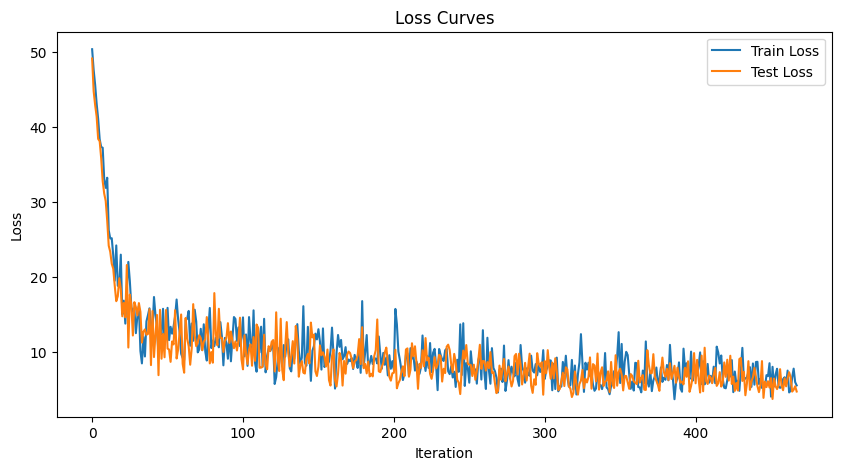

In [22]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

损失曲线是有噪声的，因为损失是在每次迭代时跟踪的，而不是多次迭代的平均值。

## 8.2 测试集的精度

该函数对所有迷你批进行迭代，以获得测试集中全部 10,000 个样本的准确度。

In [23]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9057/10000
Test Set Accuracy: 90.57%


就是这样！这就是静态 MNIST。你可以随意调整网络参数、超参数、衰减率、使用学习率调度程序等，看看能否提高网络性能。

# 结论
现在你知道如何在静态数据集上构建和训练全连接网络了吧。尖峰神经元还可以调整为其他层类型，包括卷积和跳接。有了这些知识，你现在应该能够构建多种不同类型的 SNN。[在下一篇教程](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)中，您将学习如何训练尖峰卷积网络，并使用 `snn.backprop` 模块简化所需的代码量。

此外，还要特别感谢 Bugra Kaytanli 为本教程提供的宝贵反馈意见。

如果你喜欢这个项目，请考虑在 GitHub 上的 repo ⭐ 星级，因为这是最简单、最好的支持方式。

# Additional Resources

* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)